There's something very rewarding about watching a pen plotter's dance as it traces out a graphic you've previously only seen on a screen. It can also be a stark reminder of how forgiving screen graphics are by comparison, as images that render in miliseconds on screen can take ages to plot on paper.

Each line in a plot takes time in two ways: it takes time to trace the line, and it takes time to move the pen into place from the last position. As a result of the latter, the drawing order of the lines can make a big difference to how long a plot takes. It's common to generate an image that can be sped up by an order of magnitude just by choosing a better drawing order.

Some folks in the plotting community have already been generous enough to share route optimizers: [Anders Hoff](https://twitter.com/inconvergent)'s [svgsort](https://github.com/inconvergent/svgsort), [Trammell Hudson](https://twitter.com/qrs)'s [vecsort](https://github.com/osresearch/polargraph/blob/master/vecsort.c), [Windell Oskay](https://github.com/oskay)'s [AxiDraw patch](https://github.com/evil-mad/axidraw/issues/4), [Romain Testuz](https://github.com/Daekkyn)'s [InkscapeOptimizePath](https://github.com/Daekkyn/inkscapeOptimizePath).

Most of these use a “greedy” approach, in which the path is built by iteratively tracing the *closest* untraced path to the current position.  (InkscapeOptimizePath is the exception: it uses an approach based on [Eulerian cycles](http://mathworld.wolfram.com/EulerianCycle.html).) In this post I investigate whether we can do better than a greedy algorithm using a more sophisticated path solver.

# Environment Setup

As an optimization package, we'll use [Google's Optimization Tools](https://developers.google.com/optimization/). For the greedy approach, we'll use the [rtree](https://pypi.python.org/pypi/Rtree/) package. It's easiest to install through [Conda](https://conda.io/docs/) since the [libspatialindex](https://libspatialindex.github.io/) dependency is installed automatically. Also, the [svgpathtools](https://github.com/mathandy/svgpathtools) package greatly simplifies parsing and writing paths from SVG files.

In [2]:
import IPython
import svgpathtools
import colorsys
import tempfile
import os
import rtree
from collections import Counter


## Visualizing the Problem

I have an SVG file that I'd like to plot. Here's what it looks like:

Unfortunately, the drawing order is very inefficient. To show you what I mean, let's process the image in two ways:
1. Colorizing the lines based on drawing order.
2. Adding a line for each “pen transit” that is necessary to draw the lines in order.

We can use `svg2paths` to grab all the paths as a list. This function also returns a dictionary of attributes for each path, but we can ignore those.

In [6]:
# paths, _ = svgpathtools.svg2paths(file_name)

To colorize the lines, `generate_color` returns a color string from an [HSV value](https://en.wikipedia.org/wiki/HSL_and_HSV). By using different values of hue between 0 and 1, we get a nice rainbow gradient. `visualize_pen_transits` takes a list of paths like `svgpathtools` produces and renders a visualization of the transits with the notebook.

In [3]:
def generate_color(hue, saturation=1.0, value=1.0):
    rgb = colorsys.hsv_to_rgb(hue, saturation, value)
    return 'rgb({},{},{})'.format(*[int(x*255) for x in rgb])

def visualize_pen_transits(paths):
    # We will construct a new image by storing (path, attribute)
    # pairs in this list.
    parts = list()
    
    last_end = None
    for i, path in enumerate(paths):
        start = path.start
        end = path.end
        
        # Generate a color based on how far along in the plot we are.
        frac = i / (len(paths) - 1)
        color = generate_color(frac, 1.0, 1.0)

        if last_end is not None:
            # If this isn't our first path, add a line between the end of
            # the last path and the start of this one.
            parts.append((
                svgpathtools.Line(last_end, start),
                {
                    'stroke': 'black',
                    'fill': 'none',
                }
            ))
            
        last_end = end
        
        # Also draw a faded, colorized version of this path.
        parts.append((
            path,
            {
                'stroke': color,
                'fill': 'none',
                'opacity': '0.5'
            }
        ))
    
    # Write the SVG to a temporary file and load it back as an object that
    # will appear in the notebook.
    with tempfile.TemporaryDirectory() as svg_path:
        svg_file = os.path.join(svg_path, 'image.svg')
        new_paths, new_attrs = zip(*parts)
        svgpathtools.wsvg(new_paths, attributes=new_attrs, filename=svg_file)
        svg = IPython.display.SVG(svg_file)
    return svg

Let's see what the input image looks like when we visualize the transits:

In [4]:
# visualize_pen_transits(paths)

Ick! All those lines represent time the pen is just flying through the air instead of writing on the page. Surely we can do better.

## Quantifying the Problem

Now we know what a bad solution looks like, but how do we measure it? One way is to simply add up the distance that the pen travels in the “pen up” (not drawing) position. The distance in the “pen down” position is the same no matter what order we draw the lines in, so we can just ignore it.

`svgpathtools` stores an `(x, y)` coordinate pair as the complex number `x + y*j` (in Python, `j` represents the imaginary component). This simplifies the Euclidean distance calculation:

In [5]:
def dist(p1, p2):
    return abs(p1 - p2)

Using this distance function, we can define the **cost** of a route to be the travel time between the end of each path and the start of the next one. A pen plotter starts and returns to an **origin point**, so to fully account for the cost we also need to add the distance to and from the origin.

In [6]:
def cost_of_route(path, origin=0.+0j):
    # Cost from the origin to the start of the first path
    cost = dist(origin, path[0].start)
    # Cost between the end of each path and the start of the next
    cost += sum(
        dist(path[i].end, path[i+1].start) for i in range(len(path) - 1)
    )
    # Cost to return back to the origin
    cost += dist(path[-1].end, origin)
    return cost

We can now calculate the cost of the route. This will give us a perspective of how much things improve (or don't improve; I'm not giving spoilers.)

In [7]:
# initial_cost = cost_of_route(paths)
# initial_cost

## Building a Graph

Now we have a cost function that we hope to reduce by re-ordering the paths. But before we jump into that, here's another thing to consider: in addition to re-ordering the paths, we can also reverse them. In order to take advantage of that fact, we need to keep track of both the order of the paths and whether or not each one is reversed.

Rather than storing the direction explicitly, I find it easier to represent the problem by creating a graph and adding nodes to the graph for each path *and its reverse*. A valid drawing order is then a cycle through the graph, starting and returning to the origin (which is also represented as a node in the graph), which visits **exactly one** node belonging to each (path, reversed path) pair.

To build this graph, we construct a list of nodes like this: `[origin, path[0], path[0] reversed, path[1], path[1] reversed, ...]`, that is, `self.endpoints[0]` represents the origin, and then each pair of nodes that follows represents the two directions of one path. Excepting the origin (0), paths with an **odd index** correspond to **unmodified** paths from the original drawing, and paths with an **even index** correspond to their **reversed** versions.

In [8]:
class PathGraph:
    # The origin is always at index 0.
    ORIGIN = 0
    
    def __init__(self, paths, origin=0.+0j):
        """Constructs a PathGraph from the output of svgpathtools.svg2paths."""
        self.paths = paths
        # For any node i, endpoints[i] will be a pair containing that node's
        # start and end coordinates, respectively. For i==0 this represents
        # the origin.
        self.endpoints = [(origin, origin)]
        
        for path in paths:
            # For each path in the original list of paths,
            # create nodes for the path as well as its reverse.
            self.endpoints.append((path.start, path.end))
            self.endpoints.append((path.end, path.start))
    
    def get_path(self, i):
        """Returns the path corresponding to the node i."""
        index = (i - 1) // 2
        reverse = (i - 1) % 2
        path = self.paths[index]
        if reverse:
            return path.reversed()
        else:
            return path
    
    def cost(self, i, j):
        """Returns the distance between the end of path i
        and the start of path j."""
        return dist(self.endpoints[i][1], self.endpoints[j][0])
    
    def get_coordinates(self, i, end=False):
        """Returns the starting coordinates of node i as a pair,
        or the end coordinates iff end is True."""
        if end:
            endpoint = self.endpoints[i][1]
        else:
            endpoint = self.endpoints[i][0]
        return (endpoint.real, endpoint.imag)
    
    def iter_starts_with_index(self):
        """Returns a generator over (index, start coordinate) pairs,
        excluding the origin."""
        for i in range(1, len(self.endpoints)):
            yield i, self.get_coordinates(i)
    
    def get_disjoint(self, i):
        """For the node i, returns the index of the node associated with
        its path's opposite direction."""
        return ((i-1) ^ 1) + 1
    
    def iter_disjunctions(self):
        """Returns a generator over 2-element lists of indexes which must
        be mutually exclusive in a solution (i.e. pairs of nodes which represent
        the same path in opposite directions.)"""
        for i in range(1, len(self.endpoints), 2):
            yield [i, self.get_disjoint(i)]
    
    def num_nodes(self):
        """Returns the number of nodes in the graph (including the origin.)"""
        return len(self.endpoints)

In [9]:
# path_graph = PathGraph(paths)

## A Greedy Approach

Using this graph, we can implement a greedy solution. Here's how it works:
1. Start at the origin.
2. Move to the nearest node. Add the path represented by that node to the end of the solution.
3. Remove both the node you are on, and the node corresponding to the opposite direction of the same path.
4. If there are nodes remaining, return to 2.

The second step requires a bit of nuance: the naive approach of looping over every point to find the nearest can get computationally expensive. Instead, we'll use a spatial index called an [R-tree](https://en.wikipedia.org/wiki/R-tree) which is good at quickly finding the nearest node to a point.

The `PathIndex` class below takes a `PathGraph` and turns it into a data structure that can be quickly queried to find the nearest point to a given coordinate.

In [10]:
class PathIndex:
    def __init__(self, path_graph):
        self.idx = rtree.index.Index()
        self.path_graph = path_graph
        for index, coordinate in path_graph.iter_starts_with_index():
            self.idx.add(index, coordinate + coordinate)
    
    def get_nearest(self, coordinate):
        return next(self.idx.nearest(coordinate))
    
    def delete(self, index):
        coordinate = self.path_graph.get_coordinates(index)
        self.idx.delete(index, coordinate + coordinate)
    
    def delete_pair(self, index):
        self.delete(index)
        self.delete(self.path_graph.get_disjoint(index))

The `greedy_walk` function implements the logic mentioned earlier: we start at the origin, then find the nearest point and move there, deleting nodes along the way.

In [11]:
def greedy_walk(path_graph):
    path_index = PathIndex(path_graph)
    location = path_graph.get_coordinates(path_graph.ORIGIN)
    while True:
        try:
            next_point = path_index.get_nearest(location)
        except StopIteration:
            break
        location = path_graph.get_coordinates(next_point, True)
        path_index.delete_pair(next_point)
        yield next_point

In [12]:
# greedy_solution = list(greedy_walk(path_graph))

Now that we have a solution, we want to ensure that it is “valid”, i.e. that it visits all of the original paths exactly once (possibly in reverse). We also want to see if it improved on the original solution.

In [13]:
def check_valid_solution(solution, graph):
    """Check that the solution is valid: every path is visited exactly once."""
    expected = Counter(
        i for (i, _) in graph.iter_starts_with_index()
        if i < graph.get_disjoint(i)
    )
    actual = Counter(
        min(i, graph.get_disjoint(i))
        for i in solution
    )

    difference = Counter(expected)
    difference.subtract(actual)
    difference = {k:v for k,v in difference.items() if v != 0}
    if difference:
        print('Solution is not valid!'
              'Difference in node counts (expected - actual): {}'.format(difference))
        return False
    return True

def get_route_from_solution(solution, graph):
    """Converts a solution (a list of node indices) into a list
    of paths suitable for rendering."""
    # As a guard against comparing invalid "solutions",
    # ensure that this solution is valid.
    assert check_valid_solution(solution, graph)
    return [graph.get_path(i) for i in solution]

In [14]:
# greedy_route = get_route_from_solution(greedy_solution, path_graph)

In [15]:
# len(greedy_route)

Let's calculate the cost of this solution:

In [16]:
# greedy_cost = cost_of_route(greedy_route)
# greedy_cost

In [17]:
# initial_cost / greedy_cost

That's more than a 5x improvement, pretty good! Let's visualize it:

In [22]:
# visualize_pen_transits(greedy_route)

# All in one line

In [21]:
file_name = 'generated_drawings/floyd_stippling.svg'
paths, _ = svgpathtools.svg2paths(file_name)
path_graph = PathGraph(paths)
greedy_solution = list(greedy_walk(path_graph))
greedy_route = get_route_from_solution(greedy_solution, path_graph)
svgpathtools.wsvg(greedy_route, filename="./greedy_route_out.svg") #Save the path

In [36]:
# print(type(greedy_route[0]))
# print([a_path * 4 for a_path in greedy_route])

## Limitations of Greedy Approach

The problem with a greedy approach ([Gordon Gekko notwithstanding](https://www.youtube.com/watch?v=VVxYOQS6ggk)) is that we are choosing what's locally optimal at each point on the walk without concern for the side-effects of reducing the available choices later on. This problem becomes apparent if we plot the amount of ink on the page (i.e. the travel distance with the pen down) versus the pen-up transit distance.

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')

In [32]:
def ink_transit_curve(route, origin=0.+0.j, label=None):
    ink_distance = 0.
    transit_distance = 0.
    curve = list()
    last_end = origin
    
    for path in route:
        transit_distance += dist(last_end, path.start)
        ink_distance += path.length()
        curve.append((transit_distance, ink_distance))
        last_end = path.end
    transit_distance += dist(last_end, origin)
    curve.append((transit_distance, ink_distance))
    
    plt.plot(*zip(*curve), label=label)
    plt.xlabel('Pen-up travel distance')
    plt.ylabel('Ink on page')

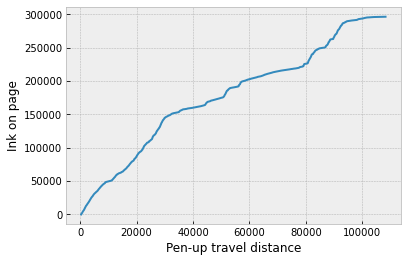

In [33]:
ink_transit_curve(greedy_route)

As you can see, the solution that this produces starts out pretty efficient with transit distance: the slope of the line is initially about 3:1, indicating that the pen is down three times as often as it is up. However, notice that the efficiency tails off towards the end of the plot: adding the last bits of ink to the page requires thrashing around the drawing area to visit all the islands we've neglected. Let's see if we can improve on this.

## A More Optimal Approach

As hinted earlier, the optimal plotting problem is tantalizingly similar to the [Traveling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem) (TSP), which looks for the shortest path that makes a complete cycle through a graph visiting every node exactly once. In fact, it can be reduced to a TSP by constructing the graph differently. My initial approach was to construct the problem as a TSP and throw [or-tools](https://github.com/google/or-tools) package's TSP solver at it. This turned out to be a false path, though, because the construction I came up with didn't optimize well.

Then I started digging through the code and noticed that the solver allows [disjunction](https://github.com/google/or-tools/blob/master/ortools/constraint_solver/routing.h#L510) constraints. This means that you can give it a pair (or more) of nodes and tell the solver to generate a route that visits *exactly one* of them. Another important feature of or-tools is that the distance function can be asymmetric. We need this since the distance function we are optimizing is the *end* of the first path to the *start* of the second, which is different if we swap the order.

What this all adds up to is that we can use the same graph structure as for the greedy approach, and as long as we make sure to tell the solver that the pairs of paths are mutually exclusive, it *just works!*

In [34]:
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2
from time import time

In [35]:
def vrp_solver(path_graph, initial_solution=None, runtime_seconds=60):
    """Solve a path using or-tools' Vehicle Routing Problem solver.
    Params:
        path_graph        the PathGraph representing the problem
        initial_solution  a solution to start with (list of indices, not
                          including the origin)
        runtime_seconds   how long to search before returning
        
    Returns: a (solution, curve) pair where the solution is a list of
        indices and the curve is a list of (clock seconds, best solution)
        pairs representing the progress of the solution over time.
    """
    manager = pywrapcp.RoutingIndexManager(path_graph.num_nodes(), 1, path_graph.ORIGIN)
    # Create the VRP routing model. The 1 means we are only looking
    # for a single path.
    routing = pywrapcp.RoutingModel(manager)
    
    # For every path node, add a disjunction so that we do not also
    # draw its reverse.
    for disjunction in path_graph.iter_disjunctions():
        routing.AddDisjunction(disjunction)
    
    # Wrap the distance function so that it converts to an integer,
    # as or-tools requires. Values are multiplied by COST_MULTIPLIER
    # prior to conversion to reduce the loss of precision.
    COST_MULTIPLIER = 1e4
    def distance(i, j):
        return int(path_graph.cost(i,j) * COST_MULTIPLIER)
    print("setting cost")
    print(routing)
    transit_callback_index = routing.RegisterTransitCallback(distance)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    
    # In order to produce a graph of the search progress, keep track
    # of the start time and (time, value) pairs.
    start_time = time()
    solution_curve = list()
    def record_solution():
        t = time() - start_time
        solution_curve.append((t, routing.CostVar().Max() / COST_MULTIPLIER))
    print("adding callbacks")
    routing.AddAtSolutionCallback(record_solution)
    
    # If we weren't supplied with a solution initially, construct one by taking
    # all of the paths in their original direction, in their original order.
    if not initial_solution:
        initial_solution = [i for i, _ in path_graph.iter_disjunctions()]
    
    # Compute the cost of the initial solution. This is the number we hope to
    # improve on.
    print("read assignment")
    print("here is the initial solution")
#     print(initial_solution)
    initial_assignment = routing.ReadAssignmentFromRoutes([initial_solution], False)
    return initial_assignment, routing, manager

def continue_vrp_solver(initial_assignment, routing, manager, runtime_seconds = None):
    COST_MULTIPLIER = 1e4

    print('Initial distance:', initial_assignment.ObjectiveValue() / COST_MULTIPLIER)
    
    # Set the parameters of the search.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.time_limit.seconds = runtime_seconds
    search_parameters.local_search_metaheuristic = (
            routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    
    # Run the optimizer and report the final distance.
    assignment = routing.SolveFromAssignmentWithParameters(initial_assignment, search_parameters)
    print('Final distance:', assignment.ObjectiveValue() / COST_MULTIPLIER)
    
    # Iterate over the result to produce a list to return as the solution.
    solution = []
    index = routing.Start(0)
    while not routing.IsEnd(index):
        index = assignment.Value(routing.NextVar(index))
        node = manager.IndexToNode(index)
        if node != 0:
            # For compatibility with the greedy solution, exclude the origin.
            solution.append(node)
    return solution

We'll prime the solver with the greedy solution to speed things up. It might seem counter-intuitive that the solver *wouldn't* start by doing its own greedy search, but remember that we had to use the raw coordinates in order to build the R-tree to run the greedy algorithm efficiently. The solver doesn't have access to the raw coordinates, since it is generalized to problems that don't use Euclidean distance.

In [ ]:
initial_assignment, routing, manager = vrp_solver(path_graph, greedy_solution, runtime_seconds=1200)

setting cost
<ortools.constraint_solver.pywrapcp.RoutingModel; proxy of <Swig Object of type 'operations_research::RoutingModel *' at 0x0000023D399A9990> >
adding callbacks
read assignment
here is the initial solution


In [ ]:
vrp_solution = continue_vrp_solver(initial_assignment, routing, manager, runtime_seconds=1200)

Note that the distances here will be slightly off, due to the loss in precision that comes with converting to integers. To get the actual figure (and also verify that the solution is valid), we can use the same methods as before:

In [ ]:
vrp_route = get_route_from_solution(vrp_solution, path_graph)
vrp_cost = cost_of_route(vrp_route)
vrp_cost

In [ ]:
vrp_cost / greedy_cost

As you can see, there is a real improvement over the greedy algorithm, even if it's not on the same order as the big improvement we got from the greedy approach.

Here's the result, visualized:

In [ ]:
visualize_pen_transits(vrp_route)

## Plotting the Optimization Curve

In addition to returning the solution, the `vrp_solver` function returns a list of the costs of solutions it found during the optimization process. Visualizing it gives us an indicator of whether we would benefit from increasing the runtime.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
plt.plot(*zip(*curve))
plt.ylabel('Pen-up distance')
plt.xlabel('Time');

## Comparing to the Greedy Solution

We can use the `ink_transit_curve` function from before to see if we have improved over the problem of the greedy solution's efficiency degrading over time. As you can see, the two approaches are roughly as efficient initially, but the vsp line maintains its slope for longer while the greedy line's slope falls off.

In [ ]:
ink_transit_curve(greedy_route, label='greedy')
ink_transit_curve(vrp_route, label='vrp')
plt.legend();

The real gain is at the end: notice that the greedy line continues after the vrp line ends. That's where it's making big moves just to draw the remaining short paths.

## Conclusion

As we have seen, the greedy step alone produced the vast majority of the efficiency improvement for this particular image. My take-away is that a greedy optimizer should be part of every plotter's toolkit, but that more extreme optimization doesn't add much. That said, there's only so much that can be concluded from looking at a single plot, and it is possible that certain plotting techniques are more likely than others to lead to plots that “trap” a greedy optimizer into an inefficient solution.